In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
df = pd.read_feather('../../dataset/preprocessed_data.feather')[['user_id', 'product_id', 'category_id', 'category_code', 'brand']]
df.head()

,user_id,product_id,category_id,category_code,brand
0,541312140,44600062,2103807459595387724,#unknown,shiseido
1,554748717,3900821,2053013552326770905,appliances.environment.water_heater,aqua
2,519107250,17200506,2053013559792632471,furniture.living_room.sofa,#unknown
3,550050854,1307067,2053013558920217191,computers.notebook,lenovo
4,535871217,1004237,2053013555631882655,electronics.smartphone,apple


In [3]:
total_rows = len(df)

train_size = int(total_rows * 0.9)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f'train: {len(train_df)}, test: {len(test_df)}')

del df

train: 38203885, test: 4244877


In [4]:
user_counts = train_df['user_id'].value_counts().reset_index()[['user_id', 'count']]
unique_user_ids = user_counts[user_counts['count'] >= 10]['user_id']
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
user_index_to_id = {index: user_id for index, user_id in enumerate(unique_user_ids)}

product_counts = train_df['product_id'].value_counts().reset_index()[['product_id', 'count']]
unique_product_ids = product_counts[product_counts['count'] >= 5]['product_id']
product_id_to_index = {product_id: index for index, product_id in enumerate(unique_product_ids)}
product_index_to_id = {index: product_id for index, product_id in enumerate(unique_product_ids)}

del user_counts, product_counts

In [5]:
unique_brands = train_df['brand'].unique()
brand_id_to_index = {brand: index for index, brand in enumerate(unique_brands)}
brand_index_to_id = {index: brand for index, brand in enumerate(unique_brands)}

unique_category_ids = train_df['category_id'].unique()
category_id_to_index = {category_id: index for index, category_id in enumerate(unique_category_ids)}
category_index_to_id = {index: category_id for index, category_id in enumerate(unique_category_ids)}

In [6]:
train_df = train_df[
    (train_df['user_id'].isin(unique_user_ids)) & 
    (train_df['product_id'].isin(unique_product_ids)) &
    (train_df['brand'].isin(unique_brands)) &
    (train_df['category_id'].isin(unique_category_ids))
]

test_df = test_df[
    (test_df['user_id'].isin(unique_user_ids)) & 
    (test_df['product_id'].isin(unique_product_ids)) &
    (test_df['brand'].isin(unique_brands)) &
    (test_df['category_id'].isin(unique_category_ids))
]

train_df['user_index'] = [user_id_to_index[user_id] for user_id in train_df['user_id']]
train_df['product_index'] = [product_id_to_index[product_id] for product_id in train_df['product_id']]
train_df['brand_index'] = [brand_id_to_index[brand] for brand in train_df['brand']]
train_df['category_index'] = [category_id_to_index[category_id] for category_id in train_df['category_id']]

test_df['user_index'] = [user_id_to_index[user_id] for user_id in test_df['user_id']]
test_df['product_index'] = [product_id_to_index[product_id] for product_id in test_df['product_id']]
test_df['brand_index'] = [brand_id_to_index[brand] for brand in test_df['brand']]
test_df['category_index'] = [category_id_to_index[category_id] for category_id in test_df['category_id']]

print(f'unique user ids: {len(unique_user_ids)}')
print(f'unique product ids: {len(unique_product_ids)}')
print(f'unique brands: {len(unique_brands)}')
print(f'unique category ids: {len(unique_category_ids)}')
print(f'train: {len(train_df)}, test: {len(test_df)}')

train_df.head()

unique user ids: 890624
unique product ids: 130913
unique brands: 3299
unique category ids: 613
train: 32022554, test: 2253627


,user_id,product_id,category_id,category_code,brand,user_index,product_index,brand_index,category_index
0,541312140,44600062,2103807459595387724,#unknown,shiseido,32147,28939,0,0
2,519107250,17200506,2053013559792632471,furniture.living_room.sofa,#unknown,462789,5410,2,2
3,550050854,1307067,2053013558920217191,computers.notebook,lenovo,427246,213,3,3
4,535871217,1004237,2053013555631882655,electronics.smartphone,apple,84837,43,4,4
5,512742880,1480613,2053013561092866779,computers.desktop,pulser,140152,11240,5,5


In [8]:
class FMDataset(Dataset):
    def __init__(self, df):
        self.data = []
        for user, product, brand, category in df[['user_index', 'product_index', 'brand_index', 'category_index']].values:
            self.data.append([int(user), int(product), int(brand), int(category)])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = FMDataset(train_df)
test_dataset = FMDataset(test_df)

In [9]:
print(f'train:{len(train_dataset)}, test: {len(test_dataset)}')
print(train_dataset[0])
print(test_dataset[0])

train:32022554, test: 2253627
[32147, 28939, 0, 0]
[183080, 363, 53, 4]


In [10]:
# For negative sampling
user_index_to_viewed_product_indices = train_df.groupby('user_index')['product_index'].agg(set).to_dict()
product_index_to_brand_index = dict(zip(train_df['product_index'], train_df['brand_index']))
product_index_to_category_index = dict(zip(train_df['product_index'], train_df['category_index']))
total_product_indices = train_df['product_index'].unique().tolist()

In [11]:
def collate_fn(batch):
    users = []
    products = []
    brands = []
    categories = []

    neg_users = []
    neg_products = []
    neg_brands = []
    neg_categories = []
    
    for row in batch:
        user = row[0]
        product = row[1]
        brand = row[2]
        category = row[3]

        user_viewed_product_indices = user_index_to_viewed_product_indices.get(user, [])
        negative_product = None
        while True:
            negative_product = random.choice(total_product_indices)
            if negative_product not in user_viewed_product_indices:
                break

        negative_brand = product_index_to_brand_index[negative_product]
        negative_category = product_index_to_category_index[negative_product]

        users.append(user)
        products.append(product)
        brands.append(brand)
        categories.append(category)

        neg_users.append(user)
        neg_products.append(negative_product)
        neg_brands.append(negative_brand)
        neg_categories.append(negative_category)

    pos_inputs = []
    for user, product, brand, category in zip(users, products, brands, categories):
        pos_inputs.append(([user, product, brand, category]))

    neg_inputs = []
    for user, product, brand, category in zip(neg_users, neg_products, neg_brands, neg_categories):
        neg_inputs.append(([user, product, brand, category]))
    
    return torch.LongTensor(pos_inputs), torch.LongTensor(neg_inputs)

In [12]:
batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f'train: {len(train_loader)}, test: {len(test_loader)}')

train: 7819, test: 551


In [13]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'device: {device}')

device: mps


In [14]:
class FM(nn.Module):
    def __init__(
        self,
        field_dims,
        n_factors,
    ):
        super(FM, self).__init__()

        self.fc = nn.Embedding(sum(field_dims), 1)
        self.bias = nn.Parameter(torch.zeros((1,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

        self.embedding = nn.Embedding(sum(field_dims), n_factors)
        
    def forward(self, x):
        # offsets
        x = x + x.new_tensor(self.offsets).unsqueeze(0)

        # linear out
        linear_out = self.bias + self.fc(x).sum(dim=1)

        # interaction between features
        square_of_sum = torch.sum(self.embedding(x), dim=1) ** 2
        sum_of_square = torch.sum(self.embedding(x) ** 2, dim=1)
        interaction_out = 0.5 * (square_of_sum - sum_of_square).sum(dim=1, keepdim=True)

        out = linear_out + interaction_out

        return out


class BPRLoss(nn.Module):
    def __init__(self, **kwargs):
        super(BPRLoss, self).__init__(**kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, positive, negative):
        distances = positive - negative
        loss = -torch.sum(torch.log(self.sigmoid(distances)))
        return loss

In [18]:
def create_model():
    return FM(
        field_dims=[len(unique_user_ids), len(unique_product_ids), len(unique_brands), len(unique_category_ids)],
        n_factors=8,
    ).to(device)

model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = BPRLoss().to(device)

In [19]:
def train(model, optimizer, criterion, dataloader):
    model.train()
    total_loss = 0
    total = 0

    for pos_inputs, neg_inputs in tqdm(dataloader, desc="Train"):
        pos_outputs = model(pos_inputs.to(device))
        neg_outputs = model(neg_inputs.to(device))
        loss = criterion(pos_outputs, neg_outputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total += pos_inputs.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    total = 0

    with torch.no_grad():
        for pos_inputs, neg_inputs in tqdm(dataloader, desc="Eval"):
            pos_outputs = model(pos_inputs.to(device))
            neg_outputs = model(neg_inputs.to(device))
            loss = criterion(pos_outputs, neg_outputs)

            total_loss += loss.item()
            total += pos_inputs.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [20]:
patience = 3
best_loss = float('inf')
counter = 0

n_epochs = 50
for epoch in range(n_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    eval_loss = evaluate(model, criterion, test_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}')

    if eval_loss < best_loss:
        best_loss = eval_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

Eval: 100%|██████████| 551/551 [00:06<00:00, 83.03it/s]


Epoch 1, Train Loss: 3384.0560, Eval Loss: 2088.0029


Eval: 100%|██████████| 551/551 [00:10<00:00, 52.25it/s]


Epoch 2, Train Loss: 1415.4321, Eval Loss: 1564.5861


Eval: 100%|██████████| 551/551 [00:06<00:00, 88.06it/s]


Epoch 3, Train Loss: 1047.0107, Eval Loss: 1333.3536


Eval: 100%|██████████| 551/551 [00:06<00:00, 89.33it/s]


Epoch 4, Train Loss: 857.3340, Eval Loss: 1200.0498


Eval: 100%|██████████| 551/551 [00:06<00:00, 89.28it/s]


Epoch 5, Train Loss: 732.4294, Eval Loss: 1113.9191


Eval: 100%|██████████| 551/551 [00:10<00:00, 53.87it/s]


Epoch 6, Train Loss: 632.7256, Eval Loss: 1044.8442


Eval: 100%|██████████| 551/551 [00:07<00:00, 77.33it/s]


Epoch 7, Train Loss: 547.1774, Eval Loss: 998.7610


Eval: 100%|██████████| 551/551 [00:06<00:00, 83.35it/s]


Epoch 8, Train Loss: 474.0461, Eval Loss: 963.5260


Eval: 100%|██████████| 551/551 [00:06<00:00, 86.50it/s]


Epoch 9, Train Loss: 412.6763, Eval Loss: 928.4718


Eval: 100%|██████████| 551/551 [00:10<00:00, 51.13it/s]


Epoch 10, Train Loss: 364.2057, Eval Loss: 903.2717


Eval: 100%|██████████| 551/551 [00:06<00:00, 79.55it/s]


Epoch 11, Train Loss: 326.0224, Eval Loss: 882.9252


Eval: 100%|██████████| 551/551 [00:06<00:00, 85.83it/s]


Epoch 12, Train Loss: 296.3732, Eval Loss: 867.0378


Eval: 100%|██████████| 551/551 [00:06<00:00, 87.70it/s]


Epoch 13, Train Loss: 273.5386, Eval Loss: 854.0844


Eval: 100%|██████████| 551/551 [00:10<00:00, 52.70it/s]


Epoch 14, Train Loss: 255.6642, Eval Loss: 842.6022


Eval: 100%|██████████| 551/551 [00:06<00:00, 88.29it/s]


Epoch 15, Train Loss: 241.3951, Eval Loss: 833.6270


Eval: 100%|██████████| 551/551 [00:06<00:00, 83.48it/s]


Epoch 16, Train Loss: 230.5435, Eval Loss: 826.8744


Eval: 100%|██████████| 551/551 [00:06<00:00, 86.91it/s]


Epoch 17, Train Loss: 221.2734, Eval Loss: 817.8428


Eval: 100%|██████████| 551/551 [00:11<00:00, 48.99it/s]


Epoch 18, Train Loss: 213.8865, Eval Loss: 816.6720


Eval: 100%|██████████| 551/551 [00:07<00:00, 76.34it/s]


Epoch 19, Train Loss: 207.4994, Eval Loss: 812.3788


Eval: 100%|██████████| 551/551 [00:06<00:00, 78.84it/s]


Epoch 20, Train Loss: 202.5533, Eval Loss: 802.2152


Eval: 100%|██████████| 551/551 [00:10<00:00, 54.71it/s]


Epoch 21, Train Loss: 198.3610, Eval Loss: 802.5614


Eval: 100%|██████████| 551/551 [00:06<00:00, 88.09it/s]


Epoch 22, Train Loss: 194.5347, Eval Loss: 796.2360


Eval: 100%|██████████| 551/551 [00:07<00:00, 77.27it/s]


Epoch 23, Train Loss: 191.7391, Eval Loss: 797.6984


Eval: 100%|██████████| 551/551 [00:06<00:00, 82.82it/s]


Epoch 24, Train Loss: 188.4681, Eval Loss: 792.5229


Eval: 100%|██████████| 551/551 [00:11<00:00, 49.52it/s]


Epoch 25, Train Loss: 185.9355, Eval Loss: 791.1929


Eval: 100%|██████████| 551/551 [00:06<00:00, 86.65it/s]


Epoch 26, Train Loss: 183.8370, Eval Loss: 789.1208


Eval: 100%|██████████| 551/551 [00:06<00:00, 87.54it/s]


Epoch 27, Train Loss: 181.7231, Eval Loss: 786.2811


Eval: 100%|██████████| 551/551 [00:06<00:00, 82.40it/s]


Epoch 28, Train Loss: 180.3010, Eval Loss: 786.5135


Eval: 100%|██████████| 551/551 [00:11<00:00, 48.21it/s]


Epoch 29, Train Loss: 178.4362, Eval Loss: 788.6716


Eval: 100%|██████████| 551/551 [00:06<00:00, 81.46it/s]


Epoch 30, Train Loss: 176.8976, Eval Loss: 783.9775


Eval: 100%|██████████| 551/551 [00:06<00:00, 82.09it/s]


Epoch 31, Train Loss: 176.0716, Eval Loss: 782.7494


Eval: 100%|██████████| 551/551 [00:06<00:00, 84.09it/s]


Epoch 32, Train Loss: 174.7526, Eval Loss: 784.5135


Eval: 100%|██████████| 551/551 [00:08<00:00, 65.74it/s]


Epoch 33, Train Loss: 173.6441, Eval Loss: 782.6326


Eval: 100%|██████████| 551/551 [00:06<00:00, 79.08it/s]


Epoch 34, Train Loss: 172.5298, Eval Loss: 785.4867


Eval: 100%|██████████| 551/551 [00:06<00:00, 83.08it/s]


Epoch 35, Train Loss: 171.9546, Eval Loss: 781.6494


Eval: 100%|██████████| 551/551 [00:06<00:00, 87.11it/s]


Epoch 36, Train Loss: 170.7129, Eval Loss: 780.9623


Eval: 100%|██████████| 551/551 [00:08<00:00, 66.44it/s]


Epoch 37, Train Loss: 169.9941, Eval Loss: 783.0450


Eval: 100%|██████████| 551/551 [00:06<00:00, 84.57it/s]


Epoch 38, Train Loss: 169.3334, Eval Loss: 779.6792


Eval: 100%|██████████| 551/551 [00:06<00:00, 83.94it/s]


Epoch 39, Train Loss: 168.6761, Eval Loss: 779.1719


Eval: 100%|██████████| 551/551 [00:06<00:00, 83.75it/s]


Epoch 40, Train Loss: 167.9112, Eval Loss: 778.0934


Eval: 100%|██████████| 551/551 [00:08<00:00, 66.47it/s]


Epoch 41, Train Loss: 167.7447, Eval Loss: 781.2306


Eval: 100%|██████████| 551/551 [00:06<00:00, 87.41it/s]


Epoch 42, Train Loss: 166.5450, Eval Loss: 779.2534


Eval: 100%|██████████| 551/551 [00:06<00:00, 80.66it/s]

Epoch 43, Train Loss: 166.3402, Eval Loss: 779.0682
Early stopping triggered at epoch 43


In [21]:
model = create_model()

model.load_state_dict(torch.load('best_model.pth'))

/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_72297/2931862686.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

<All keys matched successfully>

In [22]:
def recommend_all(n_sample_users=10000):
    sample_user_indicies = test_df['user_index'].unique().tolist()[:n_sample_users]
    product_indices = train_df['product_index'].unique().tolist()
    brand_indices = [product_index_to_brand_index[i] for i in product_indices]
    category_indices = [product_index_to_category_index[i] for i in product_indices]

    recommend_dict = {}
    for user in tqdm(sample_user_indicies):
        inputs = []
        for product, brand, category in zip(product_indices, brand_indices, category_indices):
            inputs.append([user, product, brand, category])

        scores = []
        for i in range(0, len(inputs), 16384):
            batch_inputs = inputs[i: i + 16384]
            batch_inputs = torch.LongTensor(batch_inputs).to(device)
            with torch.no_grad():
                batch_scores = model(batch_inputs).squeeze()
            scores.append(batch_scores)

        scores = torch.cat(scores)

        _, top_indices = torch.topk(scores, 500)
        recommend_product_indices = [product_indices[i] for i in top_indices]
        recommend_product_ids = [product_index_to_id[i] for i in recommend_product_indices]
        user_id = user_index_to_id[user]
        recommend_dict[user_id] = recommend_product_ids

    return recommend_dict

recommendations_dict = recommend_all()

100%|██████████| 10000/10000 [28:30<00:00,  5.85it/s] 


In [23]:
interaction_dict = test_df.groupby('user_id')['product_id'].agg(lambda x: list(set(x))).to_dict()

In [24]:
def calculate_metrics(topk=10):

    total_users = 0
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0

    for user_id in tqdm(interaction_dict.keys()):
        if user_id not in recommendations_dict:
            continue

        true_items = set(interaction_dict[user_id])
        recommended_items = recommendations_dict[user_id]
        top_k_items = set(recommended_items[:topk])

        # precision
        precision = len(top_k_items & true_items) / len(recommended_items)
        precision_sum += precision
        
        # recall
        recall = len(top_k_items & true_items) / len(true_items)
        recall_sum += recall

        # NDCG
        dcg = 0
        idcg = 0
        for i, item in enumerate(top_k_items):
            rel = 1 if item in true_items else 0
            dcg += (2**rel - 1) / np.log2(i + 2)
        
        ideal_ranking = sorted([1 if item in true_items else 0 for item in top_k_items], reverse=True)
        for i, rel in enumerate(ideal_ranking):
            idcg += (2**rel - 1) / np.log2(i + 2)
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_sum += ndcg

        total_users += 1
        
    mean_precision = precision_sum / total_users
    mean_recall = recall_sum / total_users
    mean_ndcg = float(ndcg_sum / total_users)

    return mean_precision, mean_recall, mean_ndcg

In [25]:
topk_values = [10, 30, 50, 100, 200, 300, 400, 500]

precisions, recalls, ndcgs = [], [], []
for topk in topk_values:
    precision, recall, ndcg = calculate_metrics(topk=topk)
    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
    print(f'precision@{topk}: {precision:.5f}, recall@{topk}: {recall:.5f}, ndcg@{topk}: {ndcg:.5f}')

100%|██████████| 201629/201629 [00:00<00:00, 1018829.06it/s]


precision@10: 0.00075, recall@10: 0.06760, ndcg@10: 0.11682


100%|██████████| 201629/201629 [00:00<00:00, 412945.67it/s]


precision@30: 0.00163, recall@30: 0.13489, ndcg@30: 0.13593


100%|██████████| 201629/201629 [00:00<00:00, 256763.92it/s]


precision@50: 0.00224, recall@50: 0.17706, ndcg@50: 0.14188


100%|██████████| 201629/201629 [00:01<00:00, 130650.57it/s]


precision@100: 0.00328, recall@100: 0.24371, ndcg@100: 0.14736


100%|██████████| 201629/201629 [00:02<00:00, 68122.24it/s]


precision@200: 0.00456, recall@200: 0.32047, ndcg@200: 0.15083


100%|██████████| 201629/201629 [00:04<00:00, 45186.17it/s]


precision@300: 0.00546, recall@300: 0.37100, ndcg@300: 0.15324


100%|██████████| 201629/201629 [00:06<00:00, 33224.88it/s]


precision@400: 0.00615, recall@400: 0.40938, ndcg@400: 0.15231


100%|██████████| 201629/201629 [00:07<00:00, 26369.43it/s]

precision@500: 0.00671, recall@500: 0.43957, ndcg@500: 0.15226


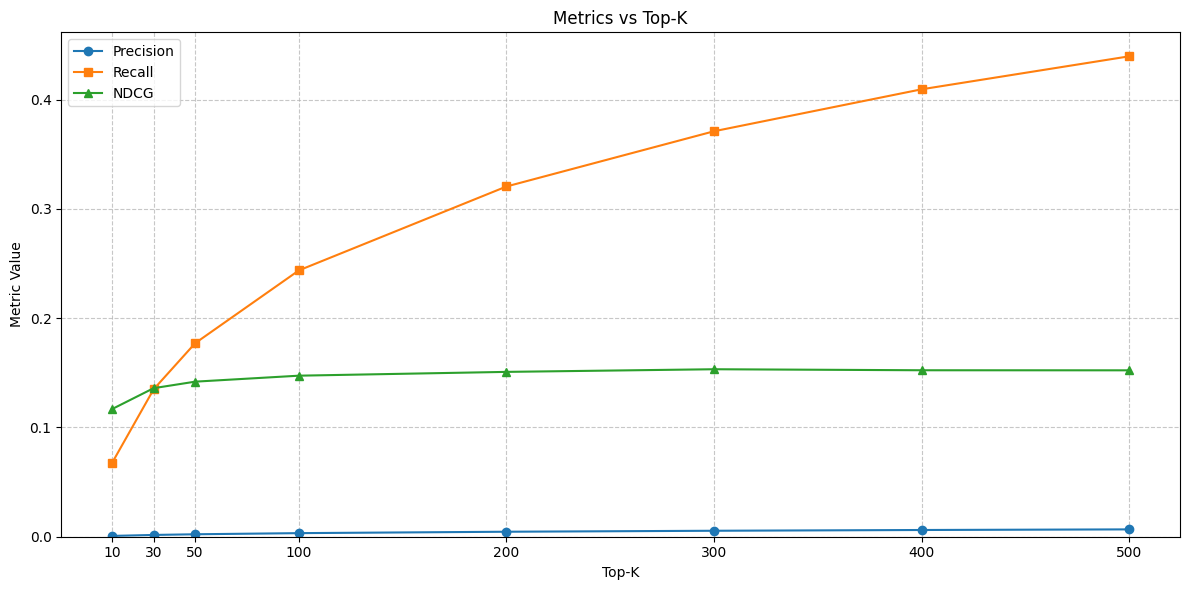

In [26]:
plt.figure(figsize=(12, 6))

plt.plot(topk_values, precisions, marker='o', label='Precision')

plt.plot(topk_values, recalls, marker='s', label='Recall')

plt.plot(topk_values, ndcgs, marker='^', label='NDCG')

plt.title('Metrics vs Top-K')
plt.xlabel('Top-K')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(topk_values)

plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

In [36]:
import random

random_user_id = random.choice(list(recommendations_dict.keys()))
print(random_user_id)

train_df[train_df['user_id'] == random_user_id]

530428730


,user_id,product_id,category_id,category_code,brand,user_index,product_index,brand_index,category_index
9568683,530428730,1306754,2053013558920217191,computers.notebook,hp,82324,677,15,3
9569828,530428730,1306754,2053013558920217191,computers.notebook,hp,82324,677,15,3
9581309,530428730,5701138,2053013553970938175,auto.accessories.player,swat,82324,11448,206,78
9581885,530428730,5701138,2053013553970938175,auto.accessories.player,swat,82324,11448,206,78
14513546,530428730,1306754,2053013558920217191,computers.notebook,hp,82324,677,15,3
...,...,...,...,...,...,...,...,...,...
24085305,530428730,1306754,2053013558920217191,computers.notebook,hp,82324,677,15,3
24086274,530428730,1306754,2053013558920217191,computers.notebook,hp,82324,677,15,3
25629011,530428730,1306754,2053013558920217191,computers.notebook,hp,82324,677,15,3
25629434,530428730,1306754,2053013558920217191,computers.notebook,hp,82324,677,15,3


In [37]:
recommend_product_ids = recommendations_dict[random_user_id]
recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
    lambda x: tuple(x[['category_code', 'brand']].iloc[0])
).to_dict()

for product_id in recommend_product_ids[:20]:
    category_code, brand = recommend_product_dict[product_id]
    print(category_code, brand)

computers.notebook lenovo
computers.notebook acer
computers.notebook acer
computers.notebook hp
computers.notebook lenovo
electronics.smartphone apple
computers.notebook lenovo
computers.notebook acer
computers.notebook hp
electronics.smartphone samsung
electronics.smartphone samsung
electronics.smartphone apple
computers.notebook hp
computers.notebook acer
computers.notebook lenovo
computers.notebook asus
#unknown cordiant
electronics.smartphone apple
computers.notebook asus
computers.notebook lenovo


/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_72297/3293158499.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
